In [1]:
import pandas as pd
import altair as alt
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np
from collections import Counter

from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import SparsePCA,PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale

from scipy.spatial.distance import cdist
%matplotlib inline

### 0) Pull Podcast data from iTunes with Applescript/Coffeescript  
In some cases podcasts don't have the 'media type' of "Podcast," but we'll ignore those for now.

```coffeescript
tell application "iTunes"
	set trackData to "name|rating|releaseDate|duration|album|artist|composer|genre|playedCount|datePlayed|dateAdded|unplayed|year\n"
	repeat with aTrack in tracks of library playlist 1
		set td to ""
		set td to td & name of aTrack & "|"
		set td to td & rating of aTrack & "|"
		set td to td & release date of aTrack & "|"
		set td to td & duration of aTrack & "|"
		set td to td & album of aTrack & "|"
		set td to td & artist of aTrack & "|"
		set td to td & composer of aTrack & "|"
		set td to td & genre of aTrack & "|"
		set td to td & played count of aTrack & "|"
		set td to td & played date of aTrack & "|"
		set td to td & date added of aTrack & "|"
		set td to td & unplayed of aTrack & "|"
		set td to td & year of aTrack & "\n"
		set trackData to trackData & td
	end repeat
	copy trackData to stdout
end tell
```  
  
This is run from bash with:
```bash
    osascript pullTrackData_upd101517.scpt > podcastdatapull_upd102117.txt
```  
  
\*<b>In this updated version 'long description' is omitted as it caused many issues with loading and parsing.<b>

### 1) set up the result

In [2]:
raw_data = pd.read_table('data/datapull_111917.txt',
                         sep='|',error_bad_lines=False, warn_bad_lines=False,
                         dtype={'year':str})
print(raw_data.shape)
raw_data.head()

(11206, 13)


,name,dateReleased,duration,album,artist,composer,genre,playedCount,datePlayed,dateAdded,unplayed,year,descriptionShort
0,Riots,"Monday, November 24, 2008 at 02:00:00",119.50700378418,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,NaN
1,Mausam & Escape,"Monday, November 24, 2008 at 02:00:00",232.839996337891,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,NaN
2,O... Saya,"Monday, November 24, 2008 at 02:00:00",213.826995849609,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & M.I.A.,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,NaN
3,Millionaire,"Monday, November 24, 2008 at 02:00:00",164.427001953125,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & Madhumitha,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,NaN
4,Latika's Theme,"Monday, November 24, 2008 at 02:00:00",189.373001098633,Slumdog Millionaire (Music from the Motion Pic...,A. R. Rahman & Suzanne,A. R. Rahman,Soundtrack,0.0,missing value,"Saturday, March 7, 2009 at 20:27:41",True,2008,NaN


### 2) Preliminary processing
- remove things with no descriprtion
- that have no played date
- that also weren't flagged as unplayed
- that also have a time duration

In [3]:
podcast_data = raw_data[  (raw_data['duration']!='missing value') 
                        & (raw_data['unplayed']!=True)
                        & (raw_data['descriptionShort']!='')
                        & (raw_data['descriptionShort'].isnull()!=True)
                        & (raw_data['datePlayed']!='missing value')
                        & (raw_data['dateReleased']!='missing value')].copy()
podcast_data.drop(['composer','descriptionShort'],axis=1,inplace=True)

podcast_data.loc[:,'datePlayed'] = pd.core.tools.datetimes.to_datetime(podcast_data['datePlayed'])
podcast_data.loc[:,'dateAdded'] = pd.core.tools.datetimes.to_datetime(podcast_data['dateAdded'])
podcast_data.loc[:,'dateReleased'] = pd.core.tools.datetimes.to_datetime(podcast_data['dateReleased'])
podcast_data.loc[:,'duration'] = podcast_data['duration'].astype(float)

# only get episodes released this year
podcast_data = podcast_data[podcast_data['dateReleased'].apply(lambda x: x.year)==2017]

# fill in year where it is missing, from dateReleased
podcast_data.loc[:,'year'] = podcast_data.apply(lambda x: str(x['dateReleased'].year) if x['year']=='0' else x['year'],axis=1)
print(podcast_data.shape)
podcast_data.head()

(2297, 11)


,name,dateReleased,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year
16,A.D.K.O.B. - Helium,2017-09-28 02:00:00,253.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-09-28 09:29:47,2017-09-28 06:43:37,False,2017
18,Aan - All You Have to Say,2017-01-20 02:00:00,214.0,KEXP Song of the Day,Aan,Podcast,1.0,2017-01-20 11:03:50,2017-01-21 11:16:12,False,2016
22,Ablebody - Backseat Heart,2017-01-02 02:00:00,297.0,KEXP Song of the Day,Ablebody,Podcast,1.0,2017-01-03 13:11:12,2017-01-30 06:15:32,False,2017
43,Ep 31: Courtney Jung on the History of Formula...,2017-07-19 18:09:13,3553.0,Adam Ruins Everything,Adam Conover & Courtney Jung,Podcast,2.0,2017-07-22 09:00:08,2017-07-21 00:15:26,False,2017
44,Ep 30: Jackie Stevens Exposes the Bizarre Worl...,2017-07-05 16:07:22,4774.0,Adam Ruins Everything,Adam Conover & Jackie Stevens,Podcast,1.0,2017-07-22 08:58:30,2017-07-21 00:23:49,False,2017


### 3) Initial generated fields
These will help with categorizations in data exploration

In [4]:
# 3.1) What was the listen day?
podcast_data['dateA_DoW'] = podcast_data['dateAdded'].dt.strftime('%a')
podcast_data['dateP_DoW'] = podcast_data['datePlayed'].dt.strftime('%a')

In [5]:
# 3.2) What part of the day was it consumed?
def bin_f(x):
    h = pd.datetime.time(x).hour
    if h < 6:
        return "em" #early morning
    elif h < 12:
        return "m" # morning
    elif h < 18:
        return "a" # afternoon
    else:
        return "e" # evening
    
podcast_data.loc[:,'dateA_Part'] = podcast_data['dateAdded'].apply(lambda i: bin_f(i))
podcast_data.loc[:,'dateP_Part'] = podcast_data['datePlayed'].apply(lambda i: bin_f(i))

In [6]:
# 3.3 How many seconds were there since adding the podcast?
# negative values indicate an error in syncing, or a new podcast subsciption
podcast_data.loc[:,'dToP_Secs'] = (podcast_data['datePlayed'] - podcast_data['dateAdded']).dt.total_seconds()
podcast_data.loc[:,'rToP_Secs'] = (podcast_data['datePlayed'] - podcast_data['dateReleased']).dt.total_seconds()

# add error indicator, this is a catch-all
podcast_data.loc[:,'syncSubError_Ind'] = podcast_data['dToP_Secs'] < 0

In [7]:
# 3.4 Was it played in the same day?
podcast_data.loc[:,'playedSameDay_Ind'] = ((podcast_data['dateA_DoW'] == podcast_data['dateP_DoW'])\
                                    & (podcast_data['dToP_Secs'] < 86400)\
                                    & (podcast_data['dToP_Secs'] >= 0)
                                    )
podcast_data.head()

,name,dateReleased,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,dateA_DoW,dateP_DoW,dateA_Part,dateP_Part,dToP_Secs,rToP_Secs,syncSubError_Ind,playedSameDay_Ind
16,A.D.K.O.B. - Helium,2017-09-28 02:00:00,253.0,KEXP Song of the Day,A.D.K.O.B.,Podcast,1.0,2017-09-28 09:29:47,2017-09-28 06:43:37,False,2017,Thu,Thu,m,m,9970.0,26987.0,False,True
18,Aan - All You Have to Say,2017-01-20 02:00:00,214.0,KEXP Song of the Day,Aan,Podcast,1.0,2017-01-20 11:03:50,2017-01-21 11:16:12,False,2016,Sat,Fri,m,m,-87142.0,32630.0,True,False
22,Ablebody - Backseat Heart,2017-01-02 02:00:00,297.0,KEXP Song of the Day,Ablebody,Podcast,1.0,2017-01-03 13:11:12,2017-01-30 06:15:32,False,2017,Mon,Tue,m,a,-2307860.0,126672.0,True,False
43,Ep 31: Courtney Jung on the History of Formula...,2017-07-19 18:09:13,3553.0,Adam Ruins Everything,Adam Conover & Courtney Jung,Podcast,2.0,2017-07-22 09:00:08,2017-07-21 00:15:26,False,2017,Fri,Sat,em,m,117882.0,226255.0,False,False
44,Ep 30: Jackie Stevens Exposes the Bizarre Worl...,2017-07-05 16:07:22,4774.0,Adam Ruins Everything,Adam Conover & Jackie Stevens,Podcast,1.0,2017-07-22 08:58:30,2017-07-21 00:23:49,False,2017,Fri,Sat,em,m,117281.0,1443068.0,False,False


### 4) Generate summary based on the current data (and wander around some data cleaning issues)
Let's start with a basic question - <b><i>when are most podcasts played?<i><b>

In [8]:
# summarize data overall by played day of week and see if there are any patterns
played_summary = podcast_data[['dateP_DoW','name']].groupby(['dateP_DoW']).count().reset_index()
played_summary.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary
         ).mark_bar().encode(
    y='dateP_DoW',
    x='count'
)

/Users/BEugeneSmith/anaconda3/lib/python3.5/site-packages/altair/utils/core.py:110: FutureWarning: pandas.lib is deprecated and will be removed in a future version.
You can access infer_dtype as pandas.api.types.infer_dtype
  typ = pd.lib.infer_dtype(data)


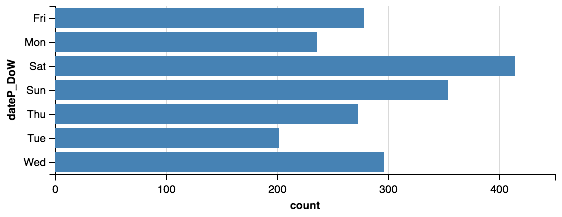

In [9]:
# What happens when we remove the instances with sync or subscription errors flagged?
podcast_data_noSSError = podcast_data[podcast_data['syncSubError_Ind']==False]
played_summary_noSSError = podcast_data_noSSError[['dateP_DoW','name']].groupby(['dateP_DoW']).count().reset_index()
played_summary_noSSError.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary_noSSError
         ).mark_bar().encode(
    y='dateP_DoW',
    x='count'
)

It looks like there's still a spike on Sunday, so why is that? I expect the following explainations to apply:  
- It doesn't interest me and I for some reason feel that I'll have time to passively consume it   
- I've put off listening to it for a while (at least a week)  
- I've just added the podcast, and don't want to go through the backlog/see it in my feed  
  
That leads to the following question - <b><i>what is the breakdown of the volume that was played on Sunday?<b><i>

In [10]:
# summarize data with no time error by day played, added, and podcast name
played_summary_by_podcast = podcast_data_noSSError[['dateP_DoW','dateA_DoW','name','dateA_Part','dateP_Part','album']]\
    .groupby(['dateP_DoW','dateA_DoW','dateA_Part','dateP_Part','album']).count().reset_index()
played_summary_by_podcast.rename(columns={'name':'count'},inplace=True)

# Isolate just the Sunday data
sundayPodcastData = played_summary_by_podcast[played_summary_by_podcast['dateP_DoW']=='Sun']
sundayPodcastData_agg = sundayPodcastData[['album','count']].groupby('album').sum().reset_index()
sundayPodcastData_agg.sort_values('count',ascending=False).head(10)

,album,count
3,All Songs Considered,18
32,On the Media,16
33,Planet Money,16
14,Global News Podcast,15
58,Wait Wait... Don't Tell Me!,14
38,Pop Culture Happy Hour,13
39,RISK!,12
25,Monocle 24: Section D,12
27,Monocle 24: The Monocle Weekly,12
57,Tiny Desk Concerts - Audio,12


Looking at the top ten podcasts played on Sunday, I would guess that I either delay playing these, or when I set up iTunes on this machine, I marked lots of episodes of this podcast as played. For some like Savage Lovecast and RISK!, that I'm less likely to listen to right away, I backlog those through the week and listen to them while doing things around the house. To capture this, I'll only consider podcasts that were listened to after the date I added KEXP Song of the Day podcast.

In [11]:
# get counts of each date type and isolate the ones that have a repeated play date
datePlayedCounts = podcast_data[['datePlayed','name']].groupby('datePlayed').count().reset_index()
datePlayedCounts_dedup = datePlayedCounts[datePlayedCounts['name']>1]['datePlayed']

# Create indicator to isolate records that are duplicates for play date and omit them
podcast_data.loc[:,'dupDate_Ind'] = (podcast_data['datePlayed'].isin(datePlayedCounts_dedup))
podcast_data = podcast_data[podcast_data['dupDate_Ind']==True]

print(podcast_data.shape)
podcast_data.head()

(251, 20)


,name,dateReleased,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,dateA_DoW,dateP_DoW,dateA_Part,dateP_Part,dToP_Secs,rToP_Secs,syncSubError_Ind,playedSameDay_Ind,dupDate_Ind
43,Ep 31: Courtney Jung on the History of Formula...,2017-07-19 18:09:13,3553.000000,Adam Ruins Everything,Adam Conover & Courtney Jung,Podcast,2.0,2017-07-22 09:00:08,2017-07-21 00:15:26,False,2017,Fri,Sat,em,m,117882.0,226255.0,False,False,True
73,Alice Boman - Dreams,2017-11-08 02:00:00,193.000000,KEXP Song of the Day,Alice Boman,Podcast,2.0,2017-11-08 21:44:14,2017-11-08 06:28:20,False,2017,Wed,Wed,m,e,54954.0,71054.0,False,True,True
83,Alvvays - In Undertow,2017-08-01 02:00:00,191.895004,KEXP Song of the Day,Alvvays,Podcast,1.0,2017-08-13 14:47:52,2017-08-01 06:44:43,False,2017,Tue,Sun,m,a,1065789.0,1082872.0,False,False,True
84,Alvvays - In Undertow,2017-08-01 02:00:00,192.000000,KEXP Song of the Day,Alvvays,Podcast,1.0,2017-08-13 14:47:52,2017-08-03 04:56:40,False,2017,Thu,Sun,em,a,899472.0,1082872.0,False,False,True
94,Ep. 34: Tina Roth Eisenberg,2017-07-10 23:01:00,3935.000000,Clever,Amy Devers + Jaime Derringer / Design Milk,Podcast,2.0,2017-07-22 09:48:09,2017-07-21 07:34:42,False,2017,Fri,Sat,m,m,94407.0,989229.0,False,False,True


This dataset gives a reasonable amount of data to work with, without the potential error of episodes that were marked as played in batch. If we were to reprocess this as above, we'd see that volumes for many of these is slightly lower, with the majority of volume still being on Sunday. 

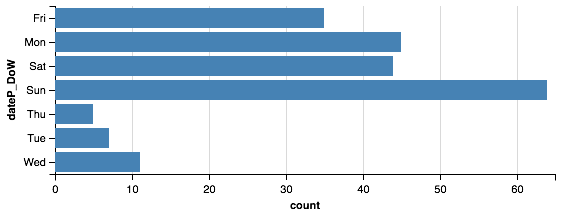

In [12]:
# What happens when we remove the instances with sync or subscription errors flagged?
podcast_data_noSSError = podcast_data[podcast_data['syncSubError_Ind']==False]
played_summary_noSSError = podcast_data_noSSError[['dateP_DoW','name']].groupby(['dateP_DoW']).count().reset_index()
played_summary_noSSError.rename(columns={'name':'count'},inplace=True)
alt.Chart(played_summary_noSSError
         ).mark_bar().encode(
    y='dateP_DoW',
    x='count'
)

In [13]:
# summarize data with no time error by day played, added, and podcast name
played_summary_by_podcast = podcast_data_noSSError[['dateP_DoW','dateA_DoW','name','dateA_Part','dateP_Part','album']]\
    .groupby(['dateP_DoW','dateA_DoW','dateA_Part','dateP_Part','album']).count().reset_index()
played_summary_by_podcast.rename(columns={'name':'count'},inplace=True)

# Isolate just the Sunday data
noDupDate_sundayPodcastData = played_summary_by_podcast[played_summary_by_podcast['dateP_DoW']=='Sun']
noDupDate_sundayPodcastData_agg = noDupDate_sundayPodcastData[['album','count']].groupby('album').sum().reset_index()
noDupDate_sundayPodcastData_agg.sort_values('count',ascending=False).head(10)

,album,count
0,All Songs Considered,9
9,Planet Money,8
14,RISK!,7
13,Pop Culture Happy Hour,6
4,KEXP Song of the Day,3
8,On the Media,3
5,Monocle 24: Section D,3
6,Monocle 24: The Urbanist,2
24,Tiny Desk Concerts - Audio,2
3,KEXP Live Performances Podcast,2


In [14]:
dupAggComp = sundayPodcastData_agg.merge(noDupDate_sundayPodcastData_agg,on='album',how='left')
dupAggComp.rename(columns={'count_x':'count_before','count_y':'count_after'},inplace=True)
dupAggComp.fillna(0,inplace=True)
dupAggComp['countDiff'] = dupAggComp['count_after'] - dupAggComp['count_before']

# Look at whihc ones were dropped altogether
dupAggComp[(dupAggComp['countDiff']<0)\
          & (dupAggComp['count_after']==0)].sort_values('countDiff')

,album,count_before,count_after,countDiff
14,Global News Podcast,15,0.0,-15.0
27,Monocle 24: The Monocle Weekly,12,0.0,-12.0
20,KEXP Presents Music That Matters,9,0.0,-9.0
17,Intelligence Squared,8,0.0,-8.0
48,Spilled Milk,7,0.0,-7.0
8,Data Skeptic,7,0.0,-7.0
60,With Friends Like These,5,0.0,-5.0
23,Lovett or Leave It,5,0.0,-5.0
11,Freakonomics Radio,4,0.0,-4.0
13,Friday Night Comedy from BBC Radio 4,4,0.0,-4.0


In [15]:
# volume of everything that can still be analyzed
dupAggComp[(dupAggComp['count_after']>0)].sort_values('countDiff')

,album,count_before,count_after,countDiff
58,Wait Wait... Don't Tell Me!,14,1.0,-13.0
32,On the Media,16,3.0,-13.0
57,Tiny Desk Concerts - Audio,12,2.0,-10.0
30,No Such Thing As A Fish,11,1.0,-10.0
25,Monocle 24: Section D,12,3.0,-9.0
3,All Songs Considered,18,9.0,-9.0
19,KEXP Live Performances Podcast,11,2.0,-9.0
28,Monocle 24: The Urbanist,10,2.0,-8.0
33,Planet Money,16,8.0,-8.0
38,Pop Culture Happy Hour,13,6.0,-7.0


The change differed by 5 on average, but this process did drop may of the podcasts I value, and consider important to my media diet, so for now they will be omitted and I'll work with those that are more likely (knowing my podcast consumption habits) to be an accurate measure of download to play date.  
  
Based on the podcasts that have been eliminated by removing the duplicates, I can already tell that this analysis will be biased towards:  
1) Podcasts that I have been listening to for a shorter period of time  
2) Podcasts that have lower frequency of release  
  
Here are some quick summary stats:

In [16]:
dupAggComp.describe()

,count_before,count_after,countDiff
count,61.000000,61.000000,61.000000
mean,5.803279,1.049180,-4.754098
std,4.403861,1.944447,3.399293
min,1.000000,0.000000,-15.000000
25%,3.000000,0.000000,-7.000000
50%,4.000000,0.000000,-4.000000
75%,7.000000,1.000000,-2.000000
max,18.000000,9.000000,0.000000


In [17]:
# a quick remidner of what our data looks like and removal of podcasts that we truly don't care about
podcast_data = podcast_data[~podcast_data['album'].isin(['My Dad Wrote A Porno','This American Life','Global News Podcast'])]
podcast_data.drop_duplicates('dToP_Secs',inplace=True)
podcast_data.head()

,name,dateReleased,duration,album,artist,genre,playedCount,datePlayed,dateAdded,unplayed,year,dateA_DoW,dateP_DoW,dateA_Part,dateP_Part,dToP_Secs,rToP_Secs,syncSubError_Ind,playedSameDay_Ind,dupDate_Ind
43,Ep 31: Courtney Jung on the History of Formula...,2017-07-19 18:09:13,3553.000000,Adam Ruins Everything,Adam Conover & Courtney Jung,Podcast,2.0,2017-07-22 09:00:08,2017-07-21 00:15:26,False,2017,Fri,Sat,em,m,117882.0,226255.0,False,False,True
73,Alice Boman - Dreams,2017-11-08 02:00:00,193.000000,KEXP Song of the Day,Alice Boman,Podcast,2.0,2017-11-08 21:44:14,2017-11-08 06:28:20,False,2017,Wed,Wed,m,e,54954.0,71054.0,False,True,True
83,Alvvays - In Undertow,2017-08-01 02:00:00,191.895004,KEXP Song of the Day,Alvvays,Podcast,1.0,2017-08-13 14:47:52,2017-08-01 06:44:43,False,2017,Tue,Sun,m,a,1065789.0,1082872.0,False,False,True
84,Alvvays - In Undertow,2017-08-01 02:00:00,192.000000,KEXP Song of the Day,Alvvays,Podcast,1.0,2017-08-13 14:47:52,2017-08-03 04:56:40,False,2017,Thu,Sun,em,a,899472.0,1082872.0,False,False,True
94,Ep. 34: Tina Roth Eisenberg,2017-07-10 23:01:00,3935.000000,Clever,Amy Devers + Jaime Derringer / Design Milk,Podcast,2.0,2017-07-22 09:48:09,2017-07-21 07:34:42,False,2017,Fri,Sat,m,m,94407.0,989229.0,False,False,True


In [18]:
def f_scale(df,col):
    return (df[col]-df[col].min())/(df[col].max()-df[col].min())

def transform_categorical_data(df,col):
    # update this
    unique_categories = list(df[col].unique())
    ix_col = col+'_ix'
    df.loc[:,ix_col] = df[col].apply(lambda x: unique_categories.index(x))
    df.loc[:,col] = f_scale(df,ix_col)
    df.drop([ix_col],axis=1,inplace=True)
    return df

def transform_continuous_data(df,col):
    df.loc[:,col] = f_scale(df,col)
    return df

def transform_dataframe(df):
    cols = df.columns
    for col in cols:
        try:
            df[col].astype(int,inplace=True)
            df = transform_continuous_data(df,col)
        except:
            df = transform_categorical_data(df,col)
    return df

In [19]:
cols = ['duration', 'album', 'playedCount','year',
       'dateA_DoW', 'dateP_DoW', 'dateA_Part', 'dateP_Part',
       'dToP_Secs','rToP_Secs']
testData_temp = podcast_data[podcast_data['syncSubError_Ind']==False][cols]

# generate normalized versions of the filtered data
testData_norm = testData_temp.copy()
testData_norm = transform_dataframe(testData_norm)

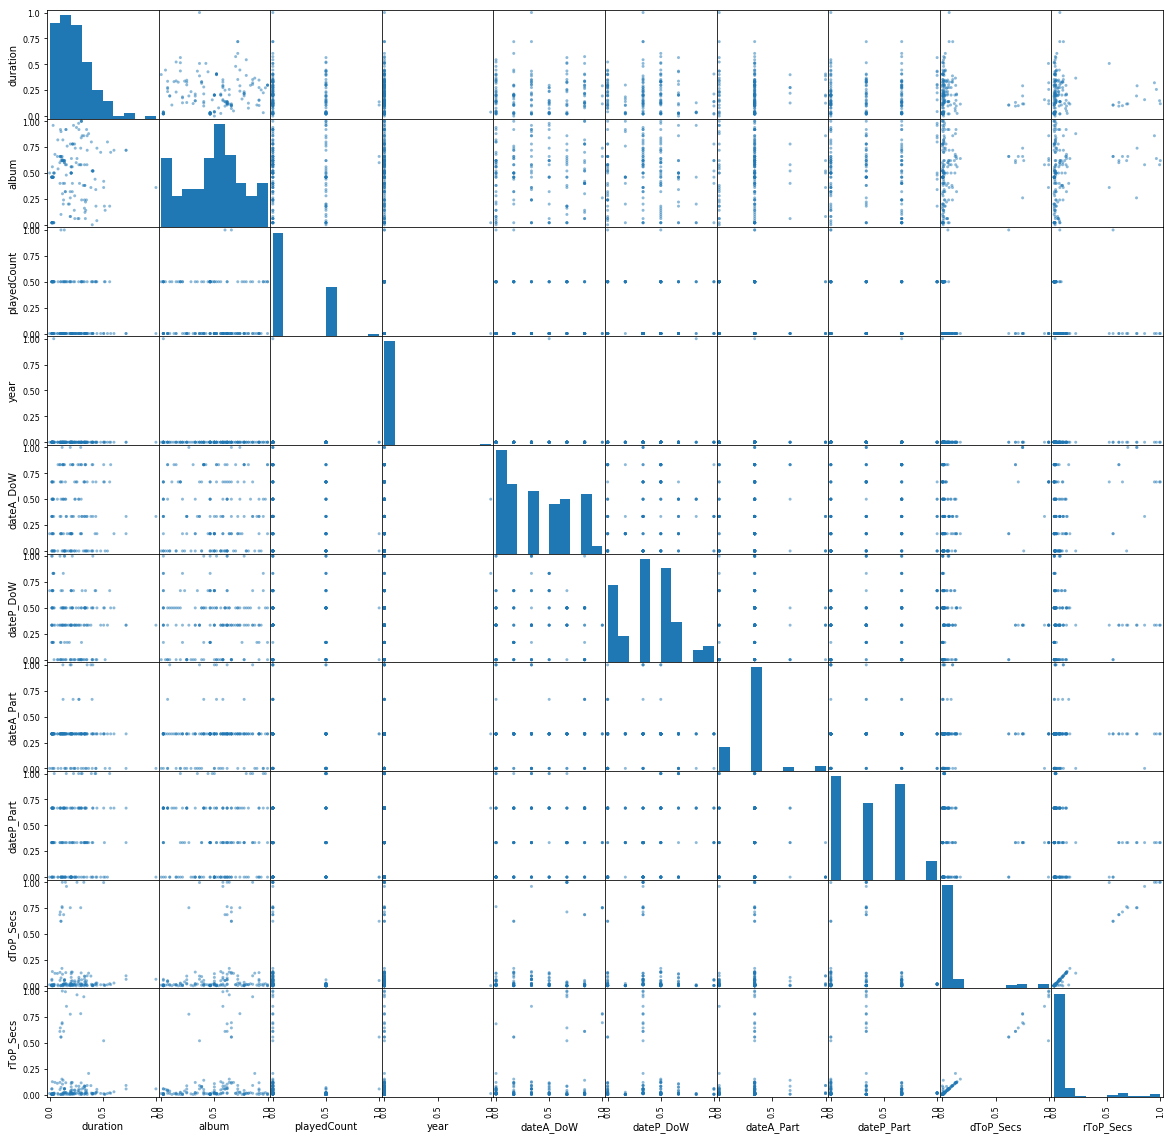

In [20]:
pd.plotting.scatter_matrix(testData_norm,figsize=[20,20])
plt.show()

Unfortunately, because most of the variables compared here are categorical, there are few cear meaningful relationships withourt looking deeper. However, there are some interactions like the one between release to play and duration, that look like interesting interactions.We will remove the top 90 percentile and work with those variables, then manually check them.

In [21]:
pct90_duration = np.percentile(testData_temp['duration'],90)
pct90_rToP_Secs = np.percentile(testData_temp['rToP_Secs'],90)

In [22]:
testData_temp = testData_temp[(testData_temp['duration']<=pct90_duration)]
                             #& (testData_temp['rToP_Secs']<=pct90_rToP_Secs)]
testData_temp[['rToP_Secs','duration']].describe()

,rToP_Secs,duration
count,1.410000e+02,141.000000
mean,2.020022e+06,1623.342318
std,4.346141e+06,1049.140918
min,3.478500e+04,5.000000
25%,1.302770e+05,868.000000
50%,3.234770e+05,1562.000000
75%,1.351848e+06,2491.000000
max,1.910928e+07,3788.000000


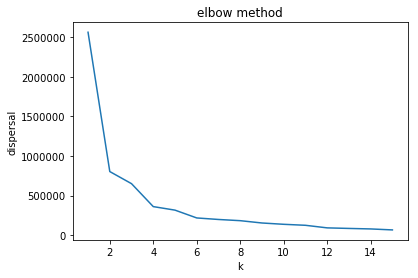

In [23]:
X = testData_temp[['duration', 'rToP_Secs']].as_matrix()

# generate elbow method model for kmeans
def elbow_method_km(df,n=10):
    dispersals = []
    K = range(1,n+1)

    for k in K:
        model = KMeans(k).fit(df)
        model.fit(df)
        dispersals.append(sum(np.min(cdist(df,model.cluster_centers_,'Euclidean',),axis=1))/df.shape[0])

    plt.plot(K,dispersals)
    plt.xlabel('k')
    plt.ylabel('dispersal')
    plt.title('elbow method')
    plt.show()
    
    #return dispersals

elbow_method_km(X,15)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.922819584636


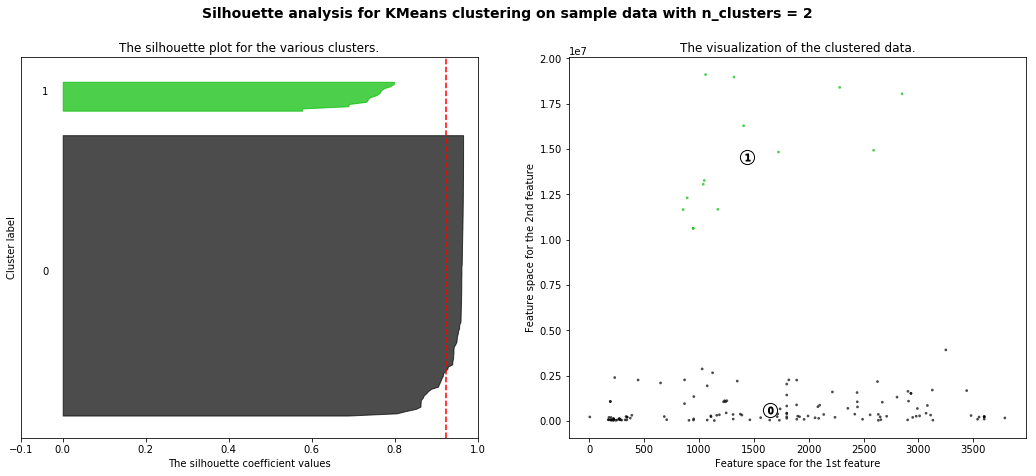

For n_clusters = 3 The average silhouette_score is : 0.906644912837


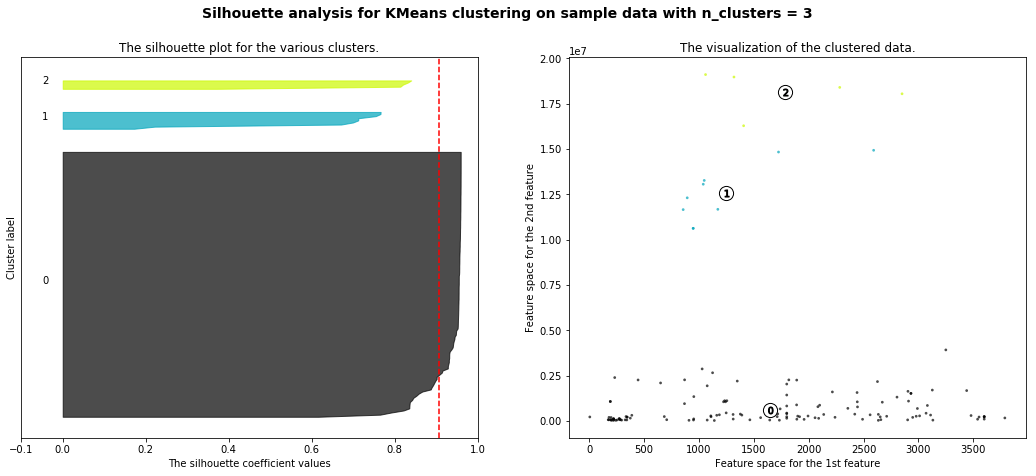

For n_clusters = 4 The average silhouette_score is : 0.737974919981


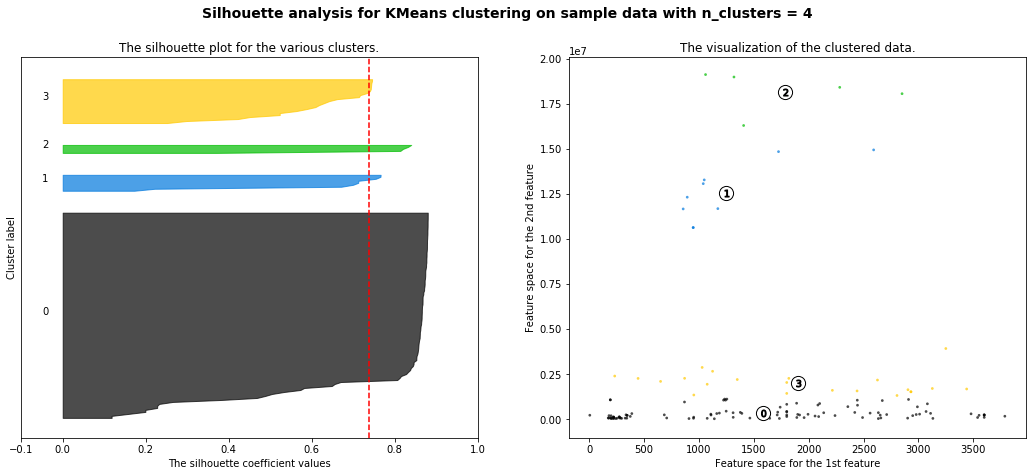

For n_clusters = 5 The average silhouette_score is : 0.73000802237


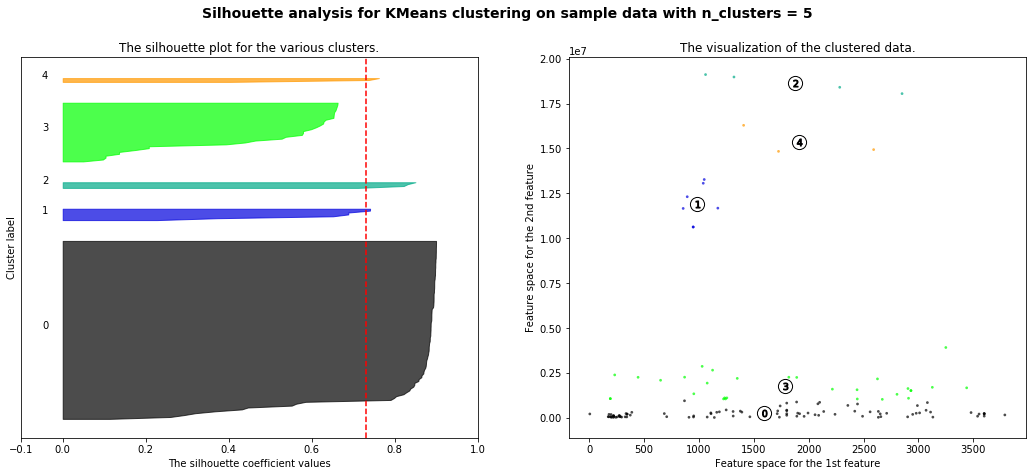

For n_clusters = 6 The average silhouette_score is : 0.738583477263


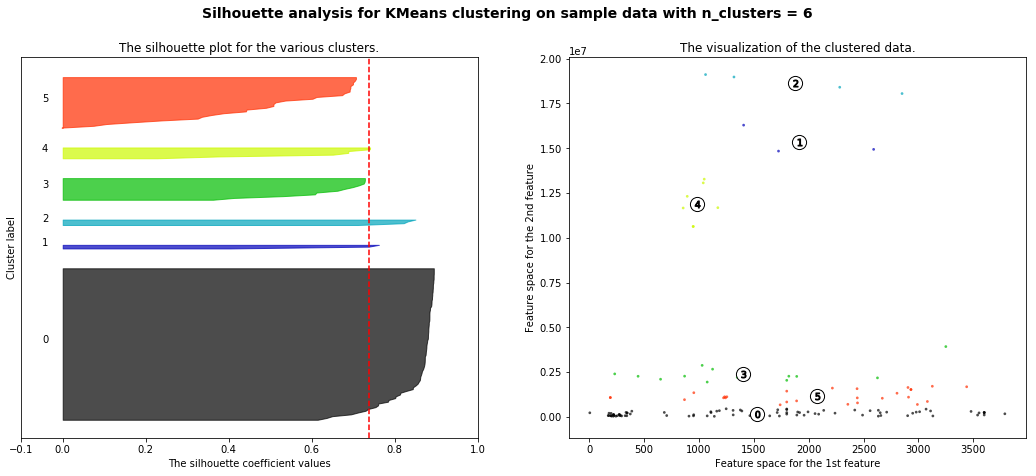

In [24]:
print(__doc__)

range_n_clusters = [2, 3, 4, 5,6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

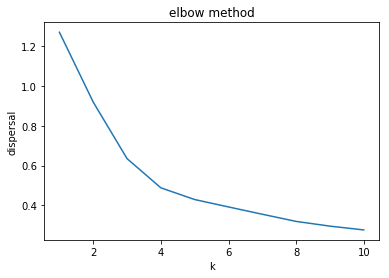

In [25]:
model = KMeans(4).fit(X)
labels = model.labels_
testData_temp['label'] = labels

label_counts = Counter(testData_temp['label'])
max_label = max(label_counts.keys(), key=(lambda k: label_counts[k]))

max_df = testData_temp[testData_temp['label']==max_label]
X = scale(max_df[['duration','rToP_Secs']].as_matrix())
elbow_method_km(X)

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.411190298434


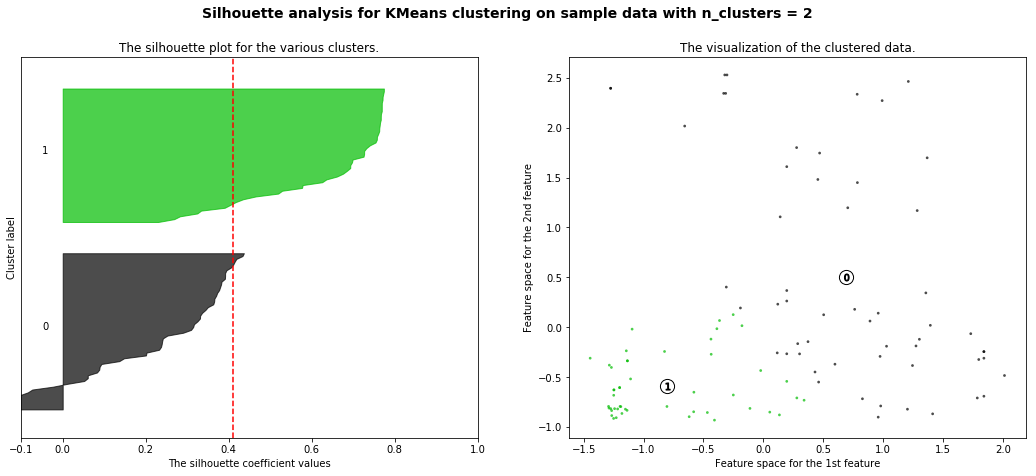

For n_clusters = 3 The average silhouette_score is : 0.529986816194


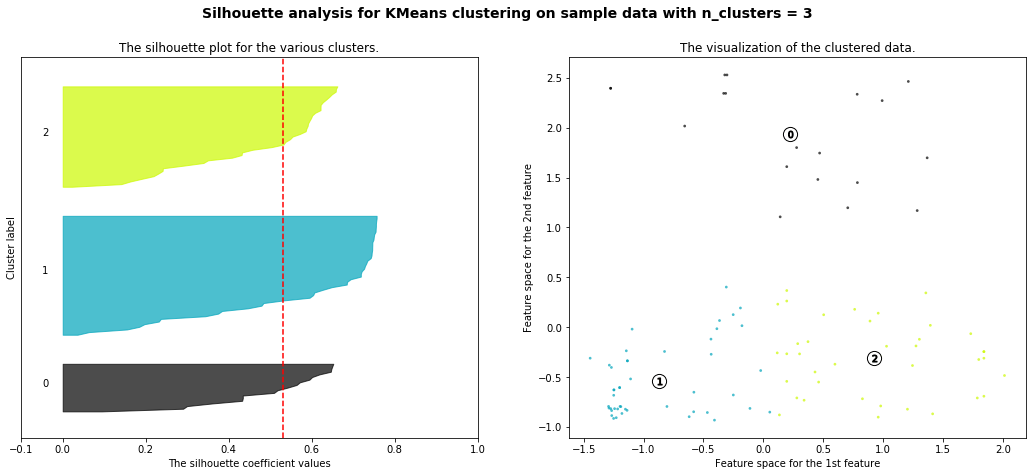

For n_clusters = 4 The average silhouette_score is : 0.517333608078


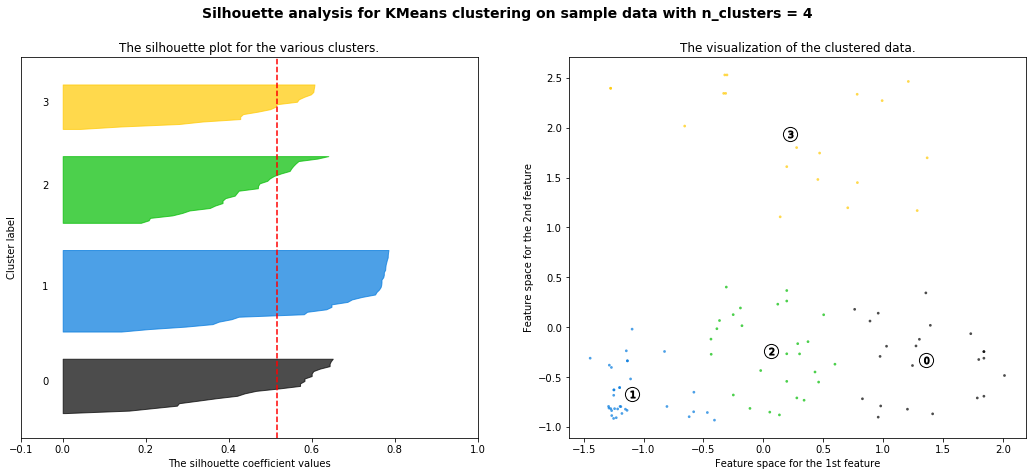

For n_clusters = 5 The average silhouette_score is : 0.529402753856


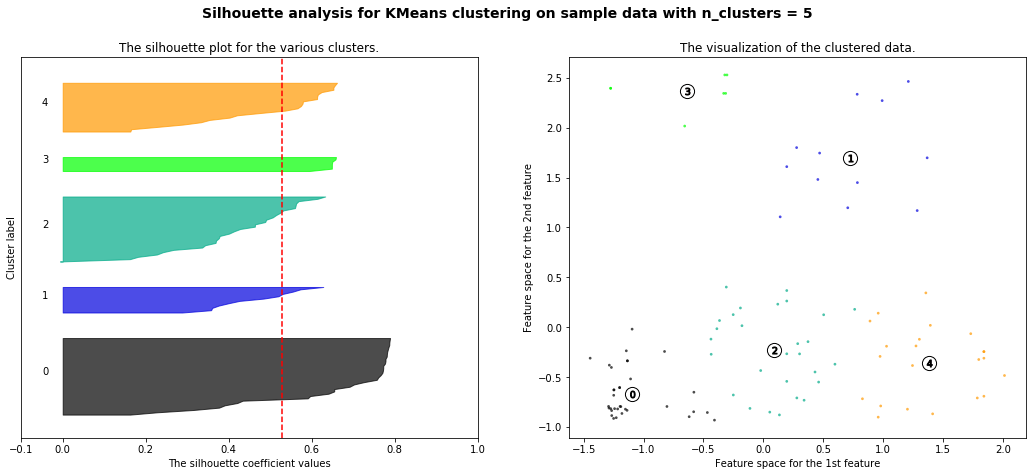

For n_clusters = 6 The average silhouette_score is : 0.498200129952


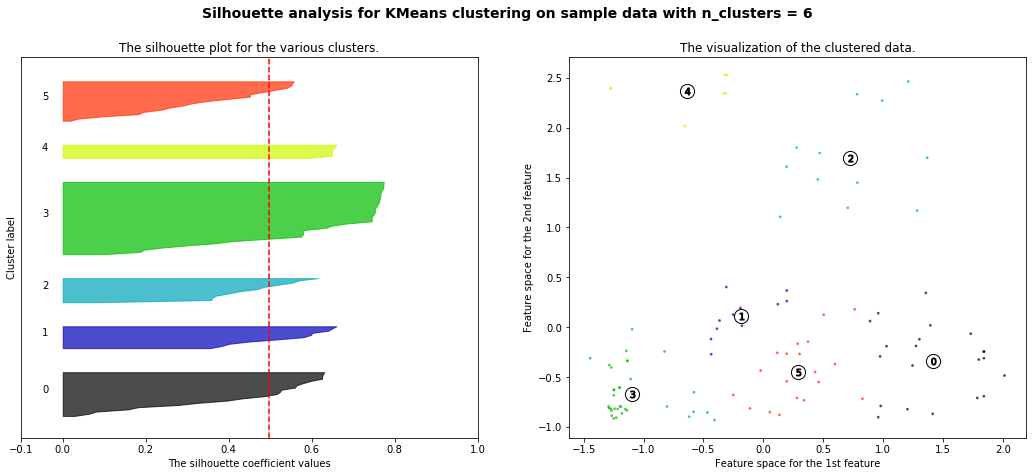

In [26]:
print(__doc__)

range_n_clusters = [2, 3, 4, 5,6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [37]:
model = KMeans(5).fit(X)
labels = model.labels_
max_df.loc[:,'label'] = labels

/Users/BEugeneSmith/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
